<a href="https://colab.research.google.com/github/giacomoaccursi/Tirocinio/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/giacomoaccursi/Tirocinio.git

Cloning into 'Tirocinio'...
remote: Enumerating objects: 16850, done.
remote: Counting objects: 100% (16850/16850), done.
remote: Compressing objects: 100% (16843/16843), done.
remote: Total 16850 (delta 13), reused 16829 (delta 4), pack-reused 0
Receiving objects: 100% (16850/16850), 7.14 MiB | 11.00 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
import json
import numpy as np
import pandas as pd

In [3]:
from os import listdir
from os.path import isfile, join
#lista tutti i file dato un percorso
def list_all_files(input_path):
  files = [join(input_path, f) for f in listdir(input_path) if isfile(join(input_path, f))]
  return list(zip(files, listdir(input_path)))

def list_all_in_dir(input_path):
  files = [join(input_path, f) for f in listdir(input_path)]
  return files

In [4]:
#dati due vettori restituisce la similarità coseno
def cosine_sim(a, b): 
  dot = np.dot(a, b)
  normA = np.linalg.norm(a)
  normB = np.linalg.norm(b)
  if normA == 0 or normB == 0: 
    return 0
  return dot / (normA * normB)
  

In [5]:
#estrae i dati dal file json
def extract_json_detection(file):
  with open(file, 'r') as f:
    data = json.load(f)
    data = data["people"][0]["pose_keypoints_2d"]
  return data

In [6]:
def coordinate_from_data(data): 
  del data[2:75:3] 
  new_data = [ [data[i], data[i+1]] for i in range(0, len(data), 2)]
  return new_data

In [7]:
def cosine_similarity_with_other_kp(detection):
  cos_sim_vector = []
  for kp in range(0, 25):
    cos_sim_vector.append([cosine_sim(detection[kp], B) for B in detection])
  return cos_sim_vector

In [8]:
keypoints = np.arange(0, 25)
video_data = []

In [9]:
outputs = sorted(list_all_in_dir("/content/Tirocinio/video_output"))
for output in outputs:
  print(output)
  files = sorted(list_all_files(output))
  vec = []
  for file in files[:100]:
    data = coordinate_from_data(extract_json_detection(file[0]))
    vec.append(cosine_similarity_with_other_kp(data))
  video_data.append(vec)

/content/Tirocinio/video_output/video_01_0
/content/Tirocinio/video_output/video_02_0
/content/Tirocinio/video_output/video_03_0
/content/Tirocinio/video_output/video_04_0
/content/Tirocinio/video_output/video_05_0
/content/Tirocinio/video_output/video_06_0
/content/Tirocinio/video_output/video_07_0
/content/Tirocinio/video_output/video_08_0
/content/Tirocinio/video_output/video_09_0
/content/Tirocinio/video_output/video_10_0
/content/Tirocinio/video_output/video_11_0
/content/Tirocinio/video_output/video_12_0
/content/Tirocinio/video_output/video_13_0
/content/Tirocinio/video_output/video_14_0
/content/Tirocinio/video_output/video_15_0
/content/Tirocinio/video_output/video_16_0
/content/Tirocinio/video_output/video_17_0
/content/Tirocinio/video_output/video_18_0
/content/Tirocinio/video_output/video_19_0
/content/Tirocinio/video_output/video_20_0
/content/Tirocinio/video_output/video_21_0
/content/Tirocinio/video_output/video_22_0
/content/Tirocinio/video_output/video_23_0
/content/Ti

In [10]:
labels = []
for output in outputs: 
  labels.append(output.split("_")[-1])

In [11]:
labels = np.array(labels)

In [12]:
video_data = np.array(video_data)

In [13]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels)

In [14]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(video_data, labels,
	test_size=0.25, stratify=labels, random_state=42)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D

model = Sequential([
                    Conv1D(16, 15, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])), 
                    Flatten(), 
                    Dense(128, activation = "relu"), 
                    Dense(128, activation = "relu"), 
                    Dense(128, activation = "relu"), 
                    Dense(y_train.shape[1], activation = "softmax")
])

In [16]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=15, batch_size=20, validation_data=(X_test, y_test))

Epoch 1/15
4/4 [==============================] - 2s 239ms/step - loss: 3.6218 - accuracy: 0.7106 - val_loss: 1.2748 - val_accuracy: 0.6087
Epoch 2/15
4/4 [==============================] - 0s 79ms/step - loss: 0.9465 - accuracy: 0.6753 - val_loss: 0.1600 - val_accuracy: 1.0000
Epoch 3/15
4/4 [==============================] - 0s 73ms/step - loss: 0.2127 - accuracy: 0.8936 - val_loss: 0.0171 - val_accuracy: 1.0000
Epoch 4/15
4/4 [==============================] - 0s 78ms/step - loss: 0.5784 - accuracy: 0.9198 - val_loss: 2.8920 - val_accuracy: 0.6087
Epoch 5/15
4/4 [==============================] - 0s 78ms/step - loss: 1.8478 - accuracy: 0.7661 - val_loss: 0.5622 - val_accuracy: 0.7826
Epoch 6/15
4/4 [==============================] - 0s 73ms/step - loss: 0.1927 - accuracy: 0.9080 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 7/15
4/4 [==============================] - 0s 71ms/step - loss: 0.0369 - accuracy: 0.9856 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 8/15
4/4 [==========

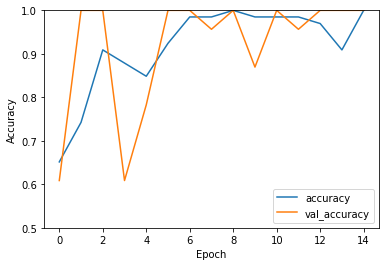

In [18]:
import matplotlib.pyplot as plt
 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [19]:
y_pred = model.predict(X_test)
y_pred = [np.argmax(i) for i in y_pred]
y_real = [np.argmax(i) for i in y_test]

In [20]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
confusion_matrix(y_real, y_pred)

array([[14,  0],
       [ 0,  9]])

In [21]:
print(classification_report(y_real, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00         9

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



In [42]:
model.predict(np.expand_dims(X_test[0], axis=0))

array([[1.0000000e+00, 1.5231591e-10]], dtype=float32)